In [15]:
import torch.nn as nn
import torch
import utils
import train
import numpy as np
import pickle5 as pickle

device = torch.device("cuda:0")
torch.cuda.is_available(), device

(True, device(type='cuda', index=0))

In [16]:
seeds = [0,1,2]
dataset = 'CIFAR100'
depth = 56
num_classes = 100
n_models = 8
confs = [25,23,21,18,16,12,8]
device_num_blocks = 6 * [27] 
for i in range(2):
    device_num_blocks += confs 
device_nums = [6] + 7*[2]

normal_base_paths = [f'saved_models/{dataset}/FedResNet{depth}_{i}/' for i in seeds]
adaptable_base_paths = [f'saved_models/{dataset}/FedAccordionResNet{depth}_{i}/' for i in seeds]
class_base_paths = [f'saved_models/{dataset}/FedClassResNet{depth}_{i}/' for i in seeds]
small_base_paths = [f'saved_models/{dataset}/FedSmallResNet{depth}_{i}/' for i in seeds]
distill_base_paths = [f'saved_models/{dataset}/FedDistillAccordionResNet{depth}_{i}/' for i in seeds]

def get_mean_test_accuracies(base_paths):
    
    accuracies = []

    for base_path in base_paths:
        with open(base_path + 'global_test_accuracies.pkl', 'rb') as f:
            acc = pickle.load(f)
            acc = np.mean(np.array(acc), axis = 1)
            accuracies.append(acc)
    
    return np.mean(accuracies, axis = 0)

normal_mean_test_accuracies = get_mean_test_accuracies(normal_base_paths)
adaptable_mean_test_accuracies = get_mean_test_accuracies(adaptable_base_paths)
small_mean_test_accuracies = get_mean_test_accuracies(small_base_paths)
distill_mean_test_accuracies = get_mean_test_accuracies(distill_base_paths)

In [17]:
class_test_accuracies = []

for base_path in class_base_paths:
    class_accuracies = []
    for i in range(n_models):
        with open(base_path + f'global_test_accuracies{i}.pkl', 'rb') as f:
            acc = pickle.load(f)
            acc = np.mean(acc, axis = 1)
            class_accuracies.append(acc)
    
    class_accuracies = np.average(class_accuracies, weights = device_nums, axis = 0)
    class_test_accuracies.append(class_accuracies)

class_mean_test_accuracies = np.mean(class_test_accuracies, axis = 0)

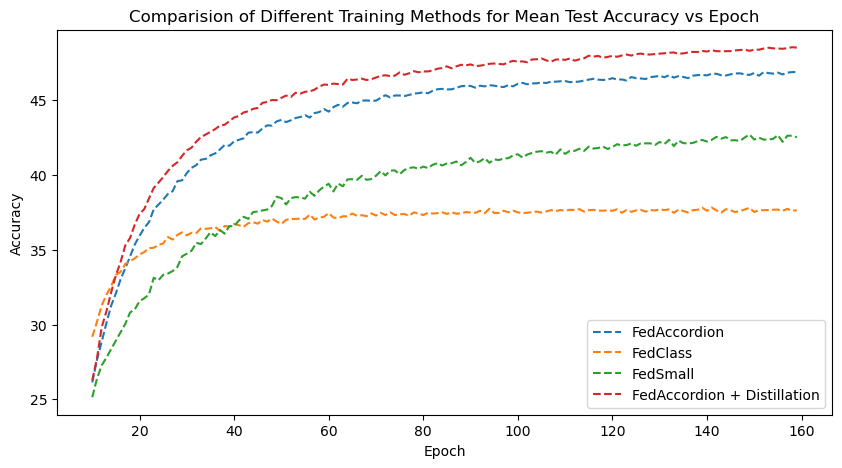

In [18]:
import matplotlib.pyplot as plt

tab = np.arange(len(normal_mean_test_accuracies))[10:]

plt.figure(figsize=(10,5))
#plt.plot(tab, normal_mean_test_accuracies, linestyle = '--', label = 'Fed')
plt.plot(tab, adaptable_mean_test_accuracies[10:], linestyle =  '--',  label = 'FedAccordion')
plt.plot(tab, class_mean_test_accuracies[10:], linestyle = '--',  label = 'FedClass')
plt.plot(tab, small_mean_test_accuracies[10:], linestyle = '--',  label = 'FedSmall')
plt.plot(tab, distill_mean_test_accuracies[10:], linestyle = '--', label = 'FedAccordion + Distillation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title("Comparision of Different Training Methods for Mean Test Accuracy vs Epoch")

plt.legend()

In [19]:
normal_mean_test_accuracies[-1], adaptable_mean_test_accuracies[-1], class_mean_test_accuracies[-1], small_mean_test_accuracies[-1], distill_mean_test_accuracies[-1]

(29.02066666666667,
 46.86466666666667,
 37.63466666666667,
 42.51,
 48.49366666666666)

In [20]:
def get_device_final_accuracies(base_paths):

    accuracies = []

    for base_path in base_paths:
        with open(base_path + 'global_test_accuracies.pkl', 'rb') as f:
            acc = pickle.load(f)[-1]
            unique_acc = []
            for a in acc:
                if a not in unique_acc or a != unique_acc[-1]:
                    unique_acc.append(a)
            accuracies.append(unique_acc)
    
    return np.mean(accuracies, axis = 0)

normal_final_device_accuracies = get_device_final_accuracies(normal_base_paths)
adaptable_final_device_accuracies = get_device_final_accuracies(adaptable_base_paths)
small_final_device_accuracies = get_device_final_accuracies(small_base_paths) 
distill_final_device_accuracies = get_device_final_accuracies(distill_base_paths)

In [21]:
normal_final_device_accuracies, adaptable_final_device_accuracies, small_final_device_accuracies, distill_final_device_accuracies

(array([67.74      , 46.87      , 21.43666667,  9.70333333,  2.86      ,
         2.25666667,  2.07333333,  1.78666667]),
 array([58.01      , 58.18666667, 57.35333333, 54.03333333, 42.68333333,
        41.99333333, 30.56      ,  9.80666667]),
 array([42.51]),
 array([59.00333333, 59.21      , 58.11      , 54.92      , 45.01333333,
        44.05666667, 34.46666667, 12.15      ]))

In [22]:
class_final_device_accuracies = []
for base_path in class_base_paths:
    class_accuracies = []
    for i in range(n_models):
        with open(base_path + f'global_test_accuracies{i}.pkl', 'rb') as f:
            acc = np.mean(pickle.load(f), axis = 1)[-1]
            class_accuracies.append(acc)
    class_final_device_accuracies.append(class_accuracies)

class_final_device_accuracies = np.mean(class_final_device_accuracies, axis = 0)

In [23]:
class_final_device_accuracies

array([52.51666667, 32.76666667, 33.4       , 34.37      , 32.14666667,
       32.05333333, 30.67666667, 23.38333333])

In [24]:
net = utils.load_model(normal_base_paths[0] + 'model', depth, num_classes, device, dataset)
model_fractions = [1.]
for block in confs:
    net.reconfigure_blocks(block)
    model_fractions.append(net.model_fraction)

model_fractions

Create ResNet-56 for CIFAR100


[1.0,
 0.8277174140845858,
 0.6554348281691715,
 0.48315224225375725,
 0.2461891699306529,
 0.2029694900729798,
 0.11653013035763353,
 0.05162609388171407]

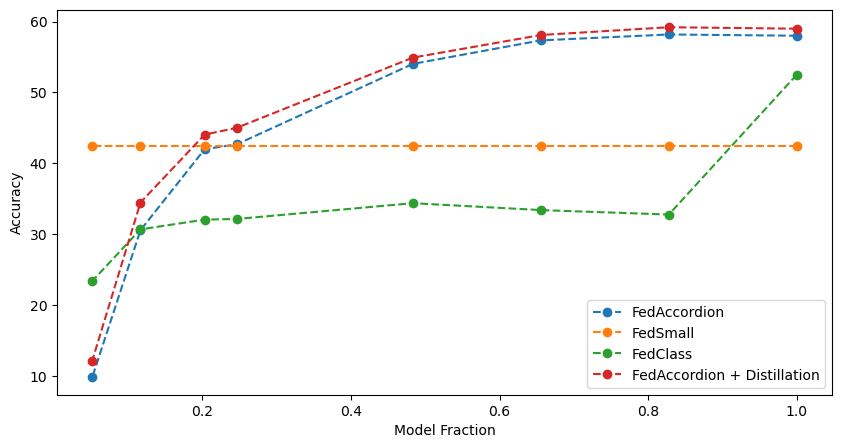

In [25]:
%matplotlib inline

plt.figure(figsize=(10,5))
plt.plot(model_fractions, adaptable_final_device_accuracies, label = 'FedAccordion', linestyle = '--', marker = 'o')
#plt.plot(model_fractions, normal_final_device_accuracies, label = 'Fed', linestyle = '--', marker = 'o')
plt.plot(model_fractions, list(small_final_device_accuracies) * n_models, label = 'FedSmall', linestyle = '--', marker = 'o')
plt.plot(model_fractions, class_final_device_accuracies, label = 'FedClass', linestyle = '--', marker = 'o')
plt.plot(model_fractions, distill_final_device_accuracies, label =  'FedAccordion + Distillation', linestyle = '--', marker = 'o')
plt.ylabel('Accuracy')
plt.xlabel('Model Fraction')
plt.title('')

plt.legend()

In [26]:
distill_final_device_accuracies

array([59.00333333, 59.21      , 58.11      , 54.92      , 45.01333333,
       44.05666667, 34.46666667, 12.15      ])